In [1]:
import os , sys
sys.path.append(os.path.abspath('./cumulo_kronen'))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis_tools import read_data
import seaborn as sns
from scipy.stats import norm

In [3]:
# Obtenemos los datos
df = read_data('./kronberger54.txt')

c:\Users\Fede\Desktop\cumulo_kronen\analysis_tools.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


# Conceptos introductorios

## Proper motion
Proper motion is the apparent angular motion of a star across the sky, as seen from Earth, due to its actual motion through space. It's measured in mas/year (milliarcseconds per year).

The total proper motion is the combination of both components: $\mu = \sqrt{pmra^{2} + pmdec^{2}}$

Where:
- pmra :  Proper Motion in Right Ascension
    - Unit: milliarcseconds per year (mas/yr)
- pmdec : Proper motion in Declination
    - Unit: milliarcseconds per year (mas/yr)

# Plane Plot

- Una vez obtenidos los datos hacemos un plane plot de los mismos
- Buscamos hacer zoom en la region donde haya mayor densidad


<Axes: xlabel='pmra', ylabel='pmdec'>

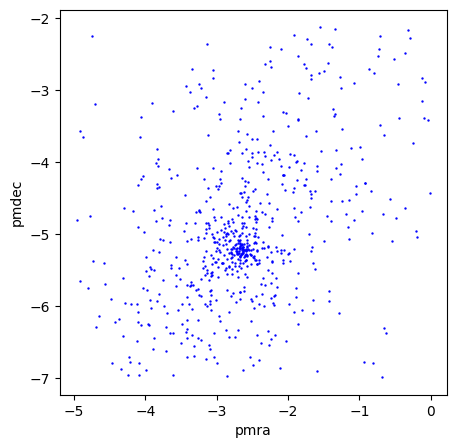

In [69]:
def plane_plot(df2, c='blue'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(df2.pmra,df2.pmdec, s=0.5, c=c)
    ax.set_xlabel('pmra')
    ax.set_ylabel('pmdec')
    return ax

def plot_color_magnitude(color, mag, c='blue'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.scatter(color,mag, s=0.9, c=c)
    ax.set_xlabel(color.name)
    ax.set_ylabel(mag.name)
    plt.gca().invert_yaxis()
    return ax

# Filtrar
df2 = df[(df.pmra>-5)&(df.pmra<0)&(df.pmdec<-2)&(df.pmdec>-7)]
# Plane plot
plane_plot(df2)

# Determinar el subset
- Vamos adeterminar bien el subconjunto con que vamos a trabajar
- Si hacemos una seleccion circular de los datos tendremos que usar una formula:

$$r=\sqrt{(x-a)^{2}+(y+b)^{2}}$$

- En topcat: Primero hay que hacer un plane plot > En la ventana del plot tendremos que usar la opcion *draw shape*. Cuando lo seleccionemos tendremos que darle un nombre: "comoving"


<Axes: xlabel='pmra', ylabel='pmdec'>

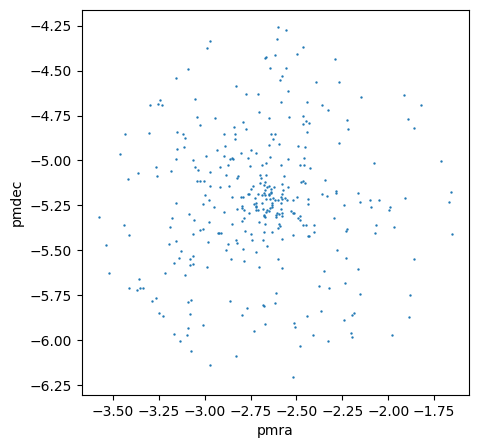

In [5]:
def circular_subset(center_ra, center_dec, radius):
    df_subset = df[
    ((df['pmra'] - center_ra) ** 2 + (df['pmdec'] - center_dec) ** 2) <= radius**2
    ]
    return df_subset

df_subset = circular_subset(-2.6,-5.25,1.0)

plane_plot(df_subset)

# Histograma de Paralajes
- En topcat tenemos que ir a la ventana de histogram>Seleccionamos subset > seleccionamos la variable a plotear : *parallax* el cual es una columna de los datos.

- El paralaje es lo que utilizaremos para determinar la distancia, sin embargo, hay que remarcar que el mismo puede ser negativo. Esto puede deberse a multiples causas, entre las cuales se encuentran los errores de medicion. El siguiente video, explica las diversas formas en las que se puede obtener paralaje negativo: <a href="https://www.youtube.com/watch?v=q4SLDLGYd3o">Video</a>

- Haremos un gaussian fit para encontrar el centro de la distribucion en cuanto a paralaje y su desviacion estandar. Esto tambien nos permite separar objetos que esten fuera del cumulo, es decir objetos con paralajes distintos de la mayoria, asi como objetos con paralajes negativos.

- Paralajes cercanos a cero son para estrellas muy lejanas , esto da como resultado una mayor incerteza en el paralaje.

- Cabe aclarar igual que hay formas de trabajar con la paralaje negativa, sin embargo, para el presente se nos recomienda hacerlo con la positiva solamente.

## Importancia del error en el paralaje

- Debemos tambien tener en cuenta el error de la paralaje, el cual se encuentra en: *parallax_error*, concretamente vamos a buscar los objetos con error relativo tal que: $\frac{\Delta parallax}{parallax} < 0.3$

- Como me quedan muy pocos objetos, utilizo 0.5 como limite

<Axes: xlabel='parallax', ylabel='Count'>

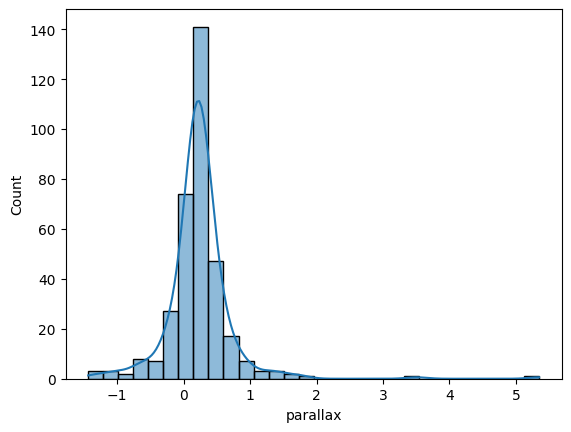

In [15]:
sns.histplot(df_subset.parallax, bins=30, kde=True) # Referencia para elaborar el histograma

In [29]:
h,b = np.histogram(df_subset.parallax, bins=30)

# calculamos el fit gaussiano
mu, std = norm.fit(df_subset.parallax)

# Con estos valores entonces restringiremos un poco mas los datos:

# df_subset_2 = df_subset[(df_subset.parallax>mu)&(df_subset.parallax<mu+std)]
df_subset_2 = df_subset[(df_subset.parallax>mu)&(df_subset.parallax<0.5)]



In [24]:
mu, mu+std

(np.float64(0.23277964331162038), np.float64(0.7447120430018338))

<Axes: xlabel='parallax', ylabel='Count'>

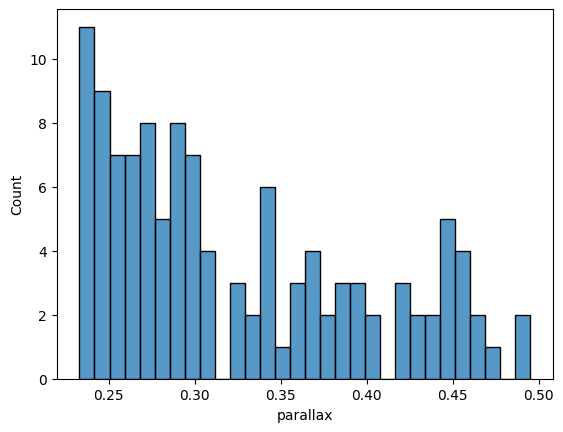

In [30]:
sns.histplot(df_subset_2.parallax, bins=30)

In [31]:
# Ahora buscamos objetos cuyo error relativo en paralaje sea menor a 0.1
# gd = good distance
df_gd = df_subset_2[(df_subset_2.parallax_error/df_subset_2.parallax) < 0.5]

<Axes: xlabel='pmra', ylabel='pmdec'>

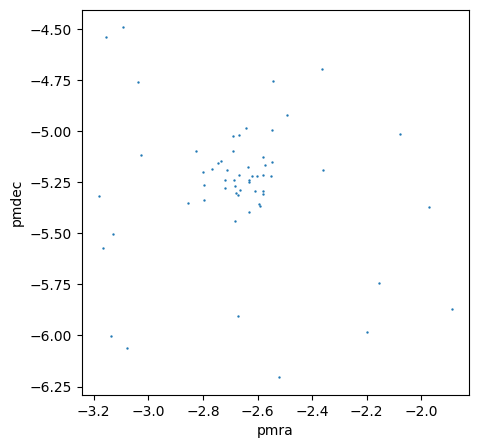

In [32]:
# Veamos que nos quedo:
plane_plot(df_gd)

# Grafico diagrama color maginitud

-  g_rp (or phot_rp_mean_mag in Gaia tables) is the mean magnitude in the RP band. It corresponds to flux measured through Gaia's Red Photometer, which covers the longer (redder) wavelengths, roughly 640–1050 nm.

- It is part of Gaia’s three-band photometry:
    - G: broad visible band (330–1050 nm)
    - BP: Blue Photometer (330–680 nm)
    - RP: Red Photometer (640–1050 nm)


- In Gaia DR3, the field phot_g_mean_mag refers to the mean apparent magnitude of a star in the Gaia G band, one of Gaia’s three broad photometric bands.


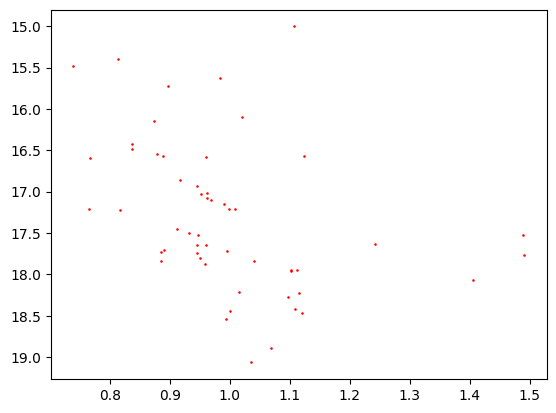

In [45]:
plt.scatter(df_gd.g_rp, df_gd.phot_g_mean_mag, s=0.7, c='red')
# plt.scatter(df_subset.g_rp, df_subset.phot_g_mean_mag,s=0.7, c='red')
plt.gca().invert_yaxis()

# Ajuste de la isocrona

- Primero debemos obtener la distancia a partir de la paralaje $d = \frac{1}{parallax}$
- Hay que tener en cuenta en gaia dr3 las unidades del paralaje esta en *miliarcosegundos* , por lo cual para determinar la distancia usando la paralaje y que nos quede en parsec, debemos usar: $d = \frac{1000}{parallax}$

- Duda: Una opcion antes de hacer esto es calcular el paralaje medio y en base a este calcular las distancias

- A poserior debemos calcular la magnitud **Absoluta**, para ello usamos la formula de modulo de distancia: $M = m - log{\frac{d}{10[pc]}}$

In [46]:
parallax_mean = np.mean(df_gd.parallax)
distance_ = 1000/parallax_mean # Distancia asociada a la paralaje media
# Calculamos la magnitud
df_gd['abs_mag'] =np.array( df_gd.phot_g_mean_mag) -  np.log10(distance_/10)

C:\Users\Fede\AppData\Local\Temp\ipykernel_12084\2493408998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gd['abs_mag'] =np.array( df_gd.phot_g_mean_mag) -  np.log10(distance_/10)


<Axes: xlabel='g_rp', ylabel='abs_mag'>

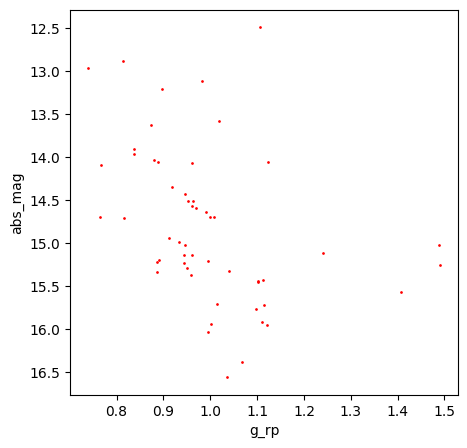

In [71]:
# plot_color_magnitude(color=df_gd.g_rp, mag=df_gd.phot_g_mean_mag, c='blue') # Antes
plot_color_magnitude(color=df_gd.g_rp, mag= df_gd.abs_mag, c='red')# Ahora con magnitud corregida

# Obtencion de la isocrona

Debemos is al siguiente <a href="https://stev.oapd.inaf.it/cgi-bin/cmd">Sitio</a>

- Evolutionary tracks> Version 1.2
- Photometric System> Gaia EDR3
- Circumstellar dust
    - Presencia de polvo estelar cambia la magnitud de esa estrella.
    - Nosotros estamos trabajando con cumulos abiertos, podemos pensar que no hay polvo
    - Elijo la opcion: No Dust
- Interstellar extinction
    - Valores de $A_{v}$ daran desplazamientos en el eje x
    - Queremos isocronas no desplazadas porque queremos corregir nuestra estrella segun la isocrona, de esta manera el corrimiento que hagamos a las estrellas en el eje x nos permitira obtener el enrojecimiento en esa region.
    - Esta variable **Debe quedar en cero** por los argumentos anteriormente mencionados.
- Long Period Variability> Lo dejamos tal como esta (valor 4)
    - Cambios solo seran necesarios si hay muchas estrellas en la region superior derecha del diagrama color magnitud.
- Initial mass function> Deralo tal y como esta
- Ages/metallicitie
    - Estamos trabajando con cumulos abiertos, los cuales tienen edades jovenes
    - Los valores de edad pueden ser o no logaritmicos, elegimos los no logaritmicos. Para valores no logaritmicos, un valor razonable es $5\times 10^{8}$, como valor inicial, mientras que para valor final tendriamos $5\times 10^{9}$
    - Un analisis del diagrama puede sugerir otros valores.
    - El valor de step para la edad debe elegirse con cuidado para que no sea pesado el archivo, se sugiere $1 \times 10^{8}$
    - Para cumulos abiertos, la metalicidad debe ser similar a la del sol
    - Para la metalicidad usamos el valor por defecto: 0.0152
    - Si queremos objetos mas jovenes que el sol, que serian mas metalicos, Z final deberia ser 0.03. Para el salto elegimos 0.01
- Outputs> sin cambios

In [53]:
# Lectura de la Isocrona
isocron = read_data("./isocrona.dat")

c:\Users\Fede\Desktop\cumulo_kronen\analysis_tools.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


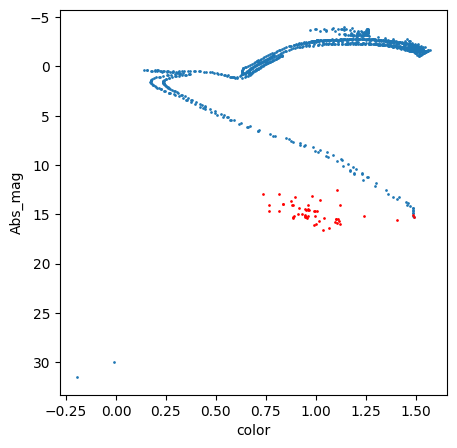

In [70]:
# Graficar la isocrona
x = isocron.Gmag - isocron.G_RPmag
y = isocron.Gmag
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(x,y, s=0.9)
ax.scatter(df_gd.g_rp, df_gd.abs_mag, c='red', s=0.9)
ax.set_xlabel('color')
ax.set_ylabel('Abs_mag')
plt.gca().invert_yaxis()
